In [1]:
#define lstm model
import torch
from torch.nn import *
import torch.nn.functional as F
from pandas_datareader import data as web
import os
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
from utils import *

In [3]:
T=30

In [4]:
etfs = ['XLB','XLE','XLF','XLI','XLP','XLV','XLY','XLU']
metrics = ["ATR","SD_Log_Close"]
start = '2001-01-01'
end = '2022-01-01'
start_t = '2023-01-01'
end_t = '2024-01-01'
models = {}

[*********************100%***********************]  1 of 1 completed


read  5284  lines of data for ticker:  XLB


[*********************100%***********************]  1 of 1 completed


read  250  lines of data for ticker:  XLB
Number of neg. ATR: 0
On the 30th day, Bought 122 shares for $9935.68
On the 31th day, Bought 0 shares for $0.0
On the 32th day, Bought 0 shares for $0.0
On the 33th day, Bought 0 shares for $0.0
On the 34th day, Bought 0 shares for $0.0
On the 35th day, Bought 0 shares for $0.0
On the 36th day, Bought 0 shares for $0.0
On the 37th day, Bought 0 shares for $0.0
On the 38th day, Bought 0 shares for $0.0
On the 56th day, Bought 0 shares for $0.0
On the 57th day, Bought 0 shares for $0.0
On the 58th day, Bought 0 shares for $0.0
On the 59th day, Bought 0 shares for $0.0
On the 60th day, Bought 0 shares for $0.0
On the 61th day, Bought 0 shares for $0.0
On the 62th day, Bought 0 shares for $0.0
On the 118th day, Bought 0 shares for $0.0
On the 126th day, Bought 0 shares for $0.0
On the 127th day, Bought 0 shares for $0.0
On the 128th day, Bought 0 shares for $0.0
On the 129th day, Bought 0 shares for $0.0
On the 130th day, Bought 0 shares for $0.0


[*********************100%***********************]  1 of 1 completed


read  5284  lines of data for ticker:  XLE


[*********************100%***********************]  1 of 1 completed


read  250  lines of data for ticker:  XLE
Number of neg. ATR: 0
On the 66th day, Bought 117 shares for $9949.68
On the 67th day, Bought 0 shares for $0.0
On the 118th day, Bought 0 shares for $0.0
On the 119th day, Bought 0 shares for $0.0
On the 158th day, Bought 0 shares for $0.0
On the 159th day, Bought 0 shares for $0.0
On the 160th day, Bought 0 shares for $0.0
On the 161th day, Bought 0 shares for $0.0
On the 163th day, Bought 0 shares for $0.0
On the 164th day, Bought 0 shares for $0.0
On the 186th day, sold 117.0 shares for $10244.52
On the 213th day, Bought 123 shares for $10290.18
On the 214th day, Bought 0 shares for $0.0
On the 215th day, Bought 0 shares for $0.0
On the 216th day, Bought 0 shares for $0.0
On the 240th day, Bought 0 shares for $0.0
On the 241th day, Bought 0 shares for $0.0
XLE Final Value: 10316.98, Final Money: 4.6599999999998545, Final Shares: 123.0


[*********************100%***********************]  1 of 1 completed


read  5284  lines of data for ticker:  XLF


[*********************100%***********************]  1 of 1 completed


read  250  lines of data for ticker:  XLF
Number of neg. ATR: 0
On the 34th day, Bought 277 shares for $9974.769999999999
On the 35th day, Bought 0 shares for $0.0
On the 36th day, Bought 0 shares for $0.0
On the 39th day, sold 277.0 shares for $8761.51
On the 114th day, Bought 266 shares for $8783.320000000002
On the 115th day, Bought 0 shares for $0.0
On the 116th day, Bought 0 shares for $0.0
On the 145th day, sold 266.0 shares for $9270.1
On the 160th day, Bought 267 shares for $9251.55
On the 161th day, Bought 0 shares for $0.0
On the 163th day, Bought 0 shares for $0.0
On the 164th day, Bought 0 shares for $0.0
On the 165th day, Bought 0 shares for $0.0
On the 166th day, Bought 0 shares for $0.0
On the 182th day, sold 267.0 shares for $8746.92
On the 208th day, Bought 260 shares for $8759.4
On the 209th day, Bought 0 shares for $0.0
On the 210th day, Bought 0 shares for $0.0
On the 211th day, Bought 0 shares for $0.0
On the 212th day, Bought 0 shares for $0.0
On the 213th day, Bo

[*********************100%***********************]  1 of 1 completed


read  5284  lines of data for ticker:  XLI


[*********************100%***********************]  1 of 1 completed


read  250  lines of data for ticker:  XLI
Number of neg. ATR: 0
On the 30th day, Bought 98 shares for $9904.859999999999
On the 31th day, Bought 0 shares for $0.0
On the 32th day, Bought 0 shares for $0.0
On the 33th day, Bought 0 shares for $0.0
On the 34th day, Bought 0 shares for $0.0
On the 35th day, Bought 0 shares for $0.0
On the 36th day, Bought 0 shares for $0.0
On the 37th day, Bought 0 shares for $0.0
On the 38th day, Bought 0 shares for $0.0
On the 39th day, Bought 0 shares for $0.0
On the 56th day, Bought 0 shares for $0.0
On the 68th day, Bought 0 shares for $0.0
On the 95th day, Bought 0 shares for $0.0
On the 96th day, Bought 0 shares for $0.0
On the 97th day, Bought 0 shares for $0.0
On the 100th day, Bought 0 shares for $0.0
On the 101th day, Bought 0 shares for $0.0
On the 102th day, Bought 0 shares for $0.0
On the 103th day, Bought 0 shares for $0.0
On the 104th day, Bought 0 shares for $0.0
On the 105th day, Bought 0 shares for $0.0
On the 106th day, Bought 0 shares

[*********************100%***********************]  1 of 1 completed


read  5284  lines of data for ticker:  XLP


[*********************100%***********************]  1 of 1 completed


read  250  lines of data for ticker:  XLP
Number of neg. ATR: 0
On the 36th day, Bought 139 shares for $9999.66
On the 37th day, Bought 0 shares for $0.0
On the 38th day, Bought 0 shares for $0.0
On the 43th day, sold 139.0 shares for $10023.289999999999
On the 53th day, Bought 134 shares for $9981.66
On the 54th day, Bought 0 shares for $0.0
On the 55th day, Bought 0 shares for $0.0
On the 56th day, Bought 0 shares for $0.0
On the 57th day, Bought 0 shares for $0.0
On the 58th day, Bought 0 shares for $0.0
On the 59th day, Bought 0 shares for $0.0
On the 60th day, Bought 0 shares for $0.0
On the 61th day, Bought 0 shares for $0.0
On the 91th day, sold 134.0 shares for $9806.12
On the 124th day, Bought 132 shares for $9774.6
On the 125th day, Bought 0 shares for $0.0
On the 126th day, Bought 0 shares for $0.0
On the 127th day, Bought 0 shares for $0.0
On the 128th day, Bought 0 shares for $0.0
On the 129th day, Bought 0 shares for $0.0
On the 141th day, sold 132.0 shares for $9863.0399

[*********************100%***********************]  1 of 1 completed


read  5284  lines of data for ticker:  XLV


[*********************100%***********************]  1 of 1 completed


read  250  lines of data for ticker:  XLV
Number of neg. ATR: 0
On the 30th day, Bought 78 shares for $9970.74
On the 31th day, Bought 0 shares for $0.0
On the 32th day, Bought 0 shares for $0.0
On the 33th day, Bought 0 shares for $0.0
On the 34th day, Bought 0 shares for $0.0
On the 35th day, Bought 0 shares for $0.0
On the 36th day, Bought 0 shares for $0.0
On the 37th day, Bought 0 shares for $0.0
On the 38th day, Bought 0 shares for $0.0
On the 39th day, Bought 0 shares for $0.0
On the 57th day, Bought 0 shares for $0.0
On the 83th day, Bought 0 shares for $0.0
On the 84th day, Bought 0 shares for $0.0
On the 85th day, Bought 0 shares for $0.0
On the 86th day, Bought 0 shares for $0.0
On the 87th day, Bought 0 shares for $0.0
On the 88th day, Bought 0 shares for $0.0
On the 112th day, Bought 0 shares for $0.0
On the 113th day, Bought 0 shares for $0.0
On the 114th day, Bought 0 shares for $0.0
On the 115th day, Bought 0 shares for $0.0
On the 116th day, Bought 0 shares for $0.0
On

[*********************100%***********************]  1 of 1 completed


read  5284  lines of data for ticker:  XLY


[*********************100%***********************]  1 of 1 completed


read  250  lines of data for ticker:  XLY
Number of neg. ATR: 0
On the 30th day, Bought 68 shares for $9897.400000000001
On the 31th day, Bought 0 shares for $0.0
On the 32th day, Bought 0 shares for $0.0
On the 33th day, Bought 0 shares for $0.0
On the 34th day, Bought 0 shares for $0.0
On the 35th day, Bought 0 shares for $0.0
On the 36th day, Bought 0 shares for $0.0
On the 37th day, Bought 0 shares for $0.0
On the 38th day, Bought 0 shares for $0.0
On the 39th day, Bought 0 shares for $0.0
On the 40th day, Bought 0 shares for $0.0
On the 41th day, Bought 0 shares for $0.0
On the 42th day, Bought 0 shares for $0.0
On the 43th day, Bought 0 shares for $0.0
On the 44th day, Bought 0 shares for $0.0
On the 45th day, Bought 0 shares for $0.0
On the 46th day, Bought 0 shares for $0.0
On the 47th day, Bought 0 shares for $0.0
On the 48th day, Bought 0 shares for $0.0
On the 49th day, Bought 0 shares for $0.0
On the 50th day, Bought 0 shares for $0.0
On the 51th day, Bought 0 shares for $0

[*********************100%***********************]  1 of 1 completed


read  5284  lines of data for ticker:  XLU


[*********************100%***********************]  1 of 1 completed


read  250  lines of data for ticker:  XLU
Number of neg. ATR: 0
On the 57th day, Bought 143 shares for $9992.84
On the 59th day, Bought 0 shares for $0.0
On the 61th day, Bought 0 shares for $0.0
On the 105th day, Bought 0 shares for $0.0
On the 106th day, Bought 0 shares for $0.0
On the 108th day, Bought 0 shares for $0.0
On the 126th day, Bought 0 shares for $0.0
On the 127th day, Bought 0 shares for $0.0
On the 147th day, Bought 0 shares for $0.0
On the 148th day, Bought 0 shares for $0.0
On the 149th day, Bought 0 shares for $0.0
On the 150th day, Bought 0 shares for $0.0
On the 151th day, Bought 0 shares for $0.0
On the 152th day, Bought 0 shares for $0.0
On the 179th day, sold 143.0 shares for $8035.17
On the 211th day, Bought 130 shares for $8035.3
On the 215th day, Bought 0 shares for $0.0
On the 219th day, Bought 0 shares for $0.0
On the 220th day, Bought 0 shares for $0.0
On the 221th day, Bought 0 shares for $0.0
On the 222th day, Bought 0 shares for $0.0
On the 223th day, B

[*********************100%***********************]  1 of 1 completed


read  5284  lines of data for ticker:  XLB


[*********************100%***********************]  1 of 1 completed


read  250  lines of data for ticker:  XLB
Number of neg. ATR: 0
On the 31th day, Bought 121 shares for $9923.210000000001
On the 32th day, Bought 0 shares for $0.0
On the 33th day, Bought 0 shares for $0.0
On the 34th day, Bought 0 shares for $0.0
On the 35th day, Bought 0 shares for $0.0
On the 93th day, Bought 1 shares for $76.18
On the 94th day, Bought 0 shares for $0.0
On the 95th day, Bought 0 shares for $0.0
On the 96th day, Bought 0 shares for $0.0
On the 108th day, Bought 0 shares for $0.0
On the 126th day, Bought 0 shares for $0.0
On the 127th day, Bought 0 shares for $0.0
On the 128th day, Bought 0 shares for $0.0
On the 129th day, Bought 0 shares for $0.0
On the 130th day, Bought 0 shares for $0.0
On the 131th day, Bought 0 shares for $0.0
On the 132th day, Bought 0 shares for $0.0
On the 146th day, Bought 0 shares for $0.0
On the 149th day, Bought 0 shares for $0.0
On the 150th day, Bought 0 shares for $0.0
On the 151th day, Bought 0 shares for $0.0
On the 152th day, Bought

[*********************100%***********************]  1 of 1 completed


read  5284  lines of data for ticker:  XLE


[*********************100%***********************]  1 of 1 completed


read  250  lines of data for ticker:  XLE
Number of neg. ATR: 0
On the 133th day, Bought 115 shares for $9960.15
On the 134th day, Bought 0 shares for $0.0
On the 183th day, sold 115.0 shares for $9858.95
On the 222th day, Bought 117 shares for $9884.16
XLE Final Value: 9823.920000000002, Final Money: 14.640000000001237, Final Shares: 117.0


[*********************100%***********************]  1 of 1 completed


read  5284  lines of data for ticker:  XLF


[*********************100%***********************]  1 of 1 completed


read  250  lines of data for ticker:  XLF
Number of neg. ATR: 0
On the 106th day, Bought 295 shares for $9971.0
On the 107th day, Bought 0 shares for $0.0
On the 148th day, sold 295.0 shares for $10027.050000000001
On the 169th day, Bought 290 shares for $10042.7
On the 174th day, sold 290.0 shares for $9784.6
On the 219th day, Bought 278 shares for $9791.16
On the 237th day, sold 278.0 shares for $10380.52
XLF Final Value: 10387.310000000001, Final Money: 10387.310000000001, Final Shares: 0.0


[*********************100%***********************]  1 of 1 completed


read  5284  lines of data for ticker:  XLI


[*********************100%***********************]  1 of 1 completed


read  250  lines of data for ticker:  XLI
Number of neg. ATR: 0
On the 55th day, Bought 98 shares for $9939.16
On the 56th day, Bought 0 shares for $0.0
On the 65th day, Bought 0 shares for $0.0
On the 66th day, Bought 0 shares for $0.0
On the 67th day, Bought 0 shares for $0.0
On the 68th day, Bought 0 shares for $0.0
On the 219th day, Bought 0 shares for $0.0
On the 220th day, Bought 0 shares for $0.0
XLI Final Value: 11231.859999999999, Final Money: 60.840000000000146, Final Shares: 98.0


[*********************100%***********************]  1 of 1 completed


read  5284  lines of data for ticker:  XLP


[*********************100%***********************]  1 of 1 completed


read  250  lines of data for ticker:  XLP
Number of neg. ATR: 0
On the 56th day, Bought 133 shares for $9996.279999999999
On the 57th day, Bought 0 shares for $0.0
On the 58th day, Bought 0 shares for $0.0
On the 59th day, Bought 0 shares for $0.0
On the 60th day, Bought 0 shares for $0.0
On the 98th day, sold 133.0 shares for $9705.01
XLP Final Value: 9708.730000000001, Final Money: 9708.730000000001, Final Shares: 0.0


[*********************100%***********************]  1 of 1 completed


read  5284  lines of data for ticker:  XLV


[*********************100%***********************]  1 of 1 completed


read  250  lines of data for ticker:  XLV
Number of neg. ATR: 0
XLV Final Value: 10000.0, Final Money: 10000, Final Shares: 0.0


[*********************100%***********************]  1 of 1 completed


read  5284  lines of data for ticker:  XLY


[*********************100%***********************]  1 of 1 completed


read  250  lines of data for ticker:  XLY
Number of neg. ATR: 0
On the 34th day, Bought 68 shares for $9974.24
On the 55th day, Bought 0 shares for $0.0
On the 62th day, Bought 0 shares for $0.0
On the 65th day, Bought 0 shares for $0.0
On the 66th day, Bought 0 shares for $0.0
On the 67th day, Bought 0 shares for $0.0
On the 69th day, Bought 0 shares for $0.0
On the 70th day, Bought 0 shares for $0.0
On the 80th day, Bought 0 shares for $0.0
On the 82th day, Bought 0 shares for $0.0
On the 86th day, Bought 0 shares for $0.0
On the 105th day, Bought 0 shares for $0.0
On the 106th day, Bought 0 shares for $0.0
On the 108th day, Bought 0 shares for $0.0
On the 109th day, Bought 0 shares for $0.0
On the 127th day, Bought 0 shares for $0.0
On the 128th day, Bought 0 shares for $0.0
On the 129th day, Bought 0 shares for $0.0
On the 165th day, Bought 0 shares for $0.0
On the 189th day, Bought 0 shares for $0.0
On the 206th day, Bought 0 shares for $0.0
On the 207th day, Bought 0 shares for $

[*********************100%***********************]  1 of 1 completed


read  5284  lines of data for ticker:  XLU


[*********************100%***********************]  1 of 1 completed


read  250  lines of data for ticker:  XLU
Number of neg. ATR: 0
On the 31th day, Bought 154 shares for $9957.64
On the 33th day, Bought 0 shares for $0.0
On the 56th day, Bought 0 shares for $0.0
On the 57th day, Bought 0 shares for $0.0
On the 58th day, Bought 0 shares for $0.0
On the 59th day, Bought 0 shares for $0.0
On the 60th day, Bought 0 shares for $0.0
On the 61th day, Bought 0 shares for $0.0
On the 62th day, Bought 0 shares for $0.0
On the 63th day, Bought 0 shares for $0.0
On the 64th day, Bought 0 shares for $0.0
On the 65th day, Bought 0 shares for $0.0
On the 66th day, Bought 0 shares for $0.0
On the 67th day, Bought 0 shares for $0.0
On the 68th day, Bought 0 shares for $0.0
On the 69th day, Bought 0 shares for $0.0
On the 70th day, Bought 0 shares for $0.0
On the 108th day, Bought 0 shares for $0.0
On the 134th day, Bought 0 shares for $0.0
On the 137th day, Bought 0 shares for $0.0
On the 138th day, Bought 0 shares for $0.0
On the 139th day, Bought 0 shares for $0.0
O

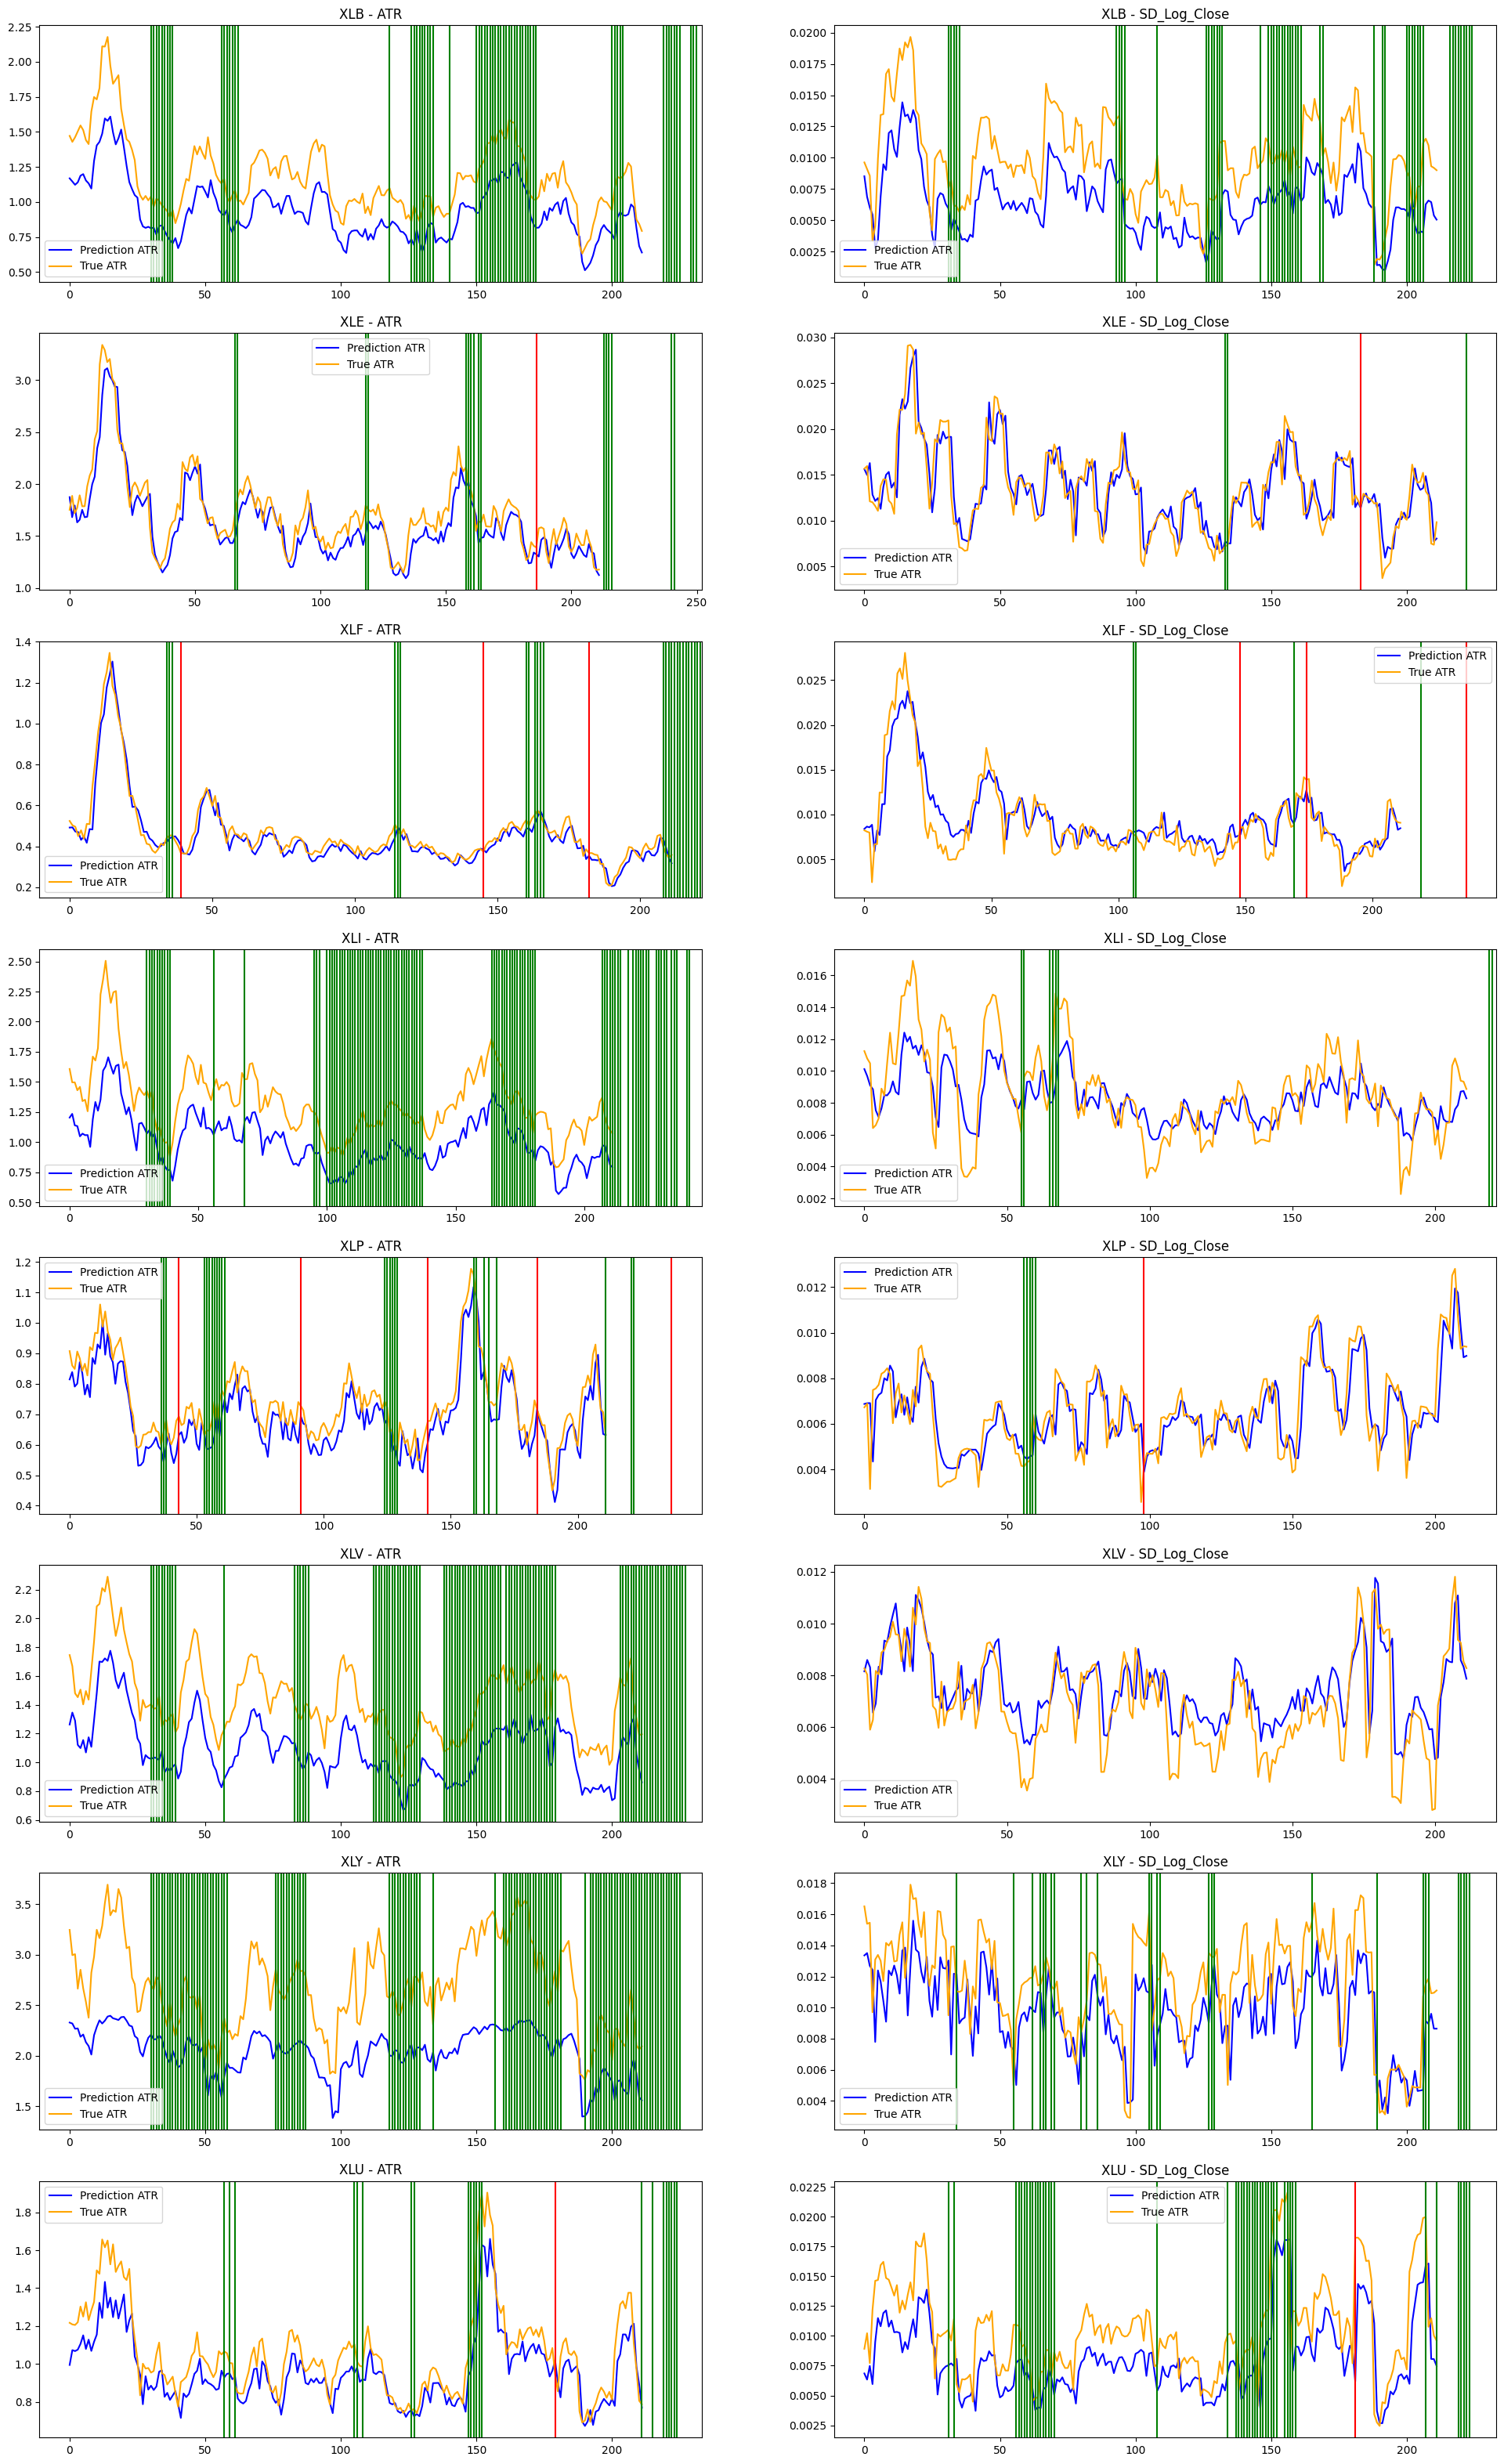

In [5]:
results = pd.DataFrame({"ETF":[],"Metric":[],"Final_Value":[],"Passive_Potential":[]})
fig,ax = plt.subplots(len(etfs),len(metrics),figsize=(24,40))
for i,metric in enumerate(metrics):
    for j,etf in enumerate(etfs):
        scaler = StandardScaler()
        df = get_cleaned_df(etf,start,end)
        #print(df)
        model = get_trained_model(df,scaler,metric=metric)
        df_test = get_cleaned_df(etf,start_t,end_t)
        print("Number of neg. ATR:",len(df_test.loc[[atr<0 for atr in df_test["ATR"]]]))
        ini_cash = 10000
        final_value, money, shares,passive_value,buy_points,sell_points,preds = backtest_strategy(df_test,model,scaler,metric)
        print(f"{etf} Final Value: {final_value}, Final Money: {money}, Final Shares: {shares}")
        results.loc[len(results)] = [etf,metric,final_value,passive_value]

        real_met = np.array(df_test[metric].iloc[T:len(df_test)-1])
        sns.lineplot(preds,ax=ax[j][i],label="Prediction ATR",color="Blue")
        sns.lineplot(real_met,ax=ax[j][i],label = "True ATR",color="Orange")
        for buy in buy_points:
            ax[j][i].axvline(buy,color="Green")
        for sell in sell_points:
            ax[j][i].axvline(sell,color="Red")
        ax[j][i].set_title(f"{etf} - {metric}")


In [11]:
fig.savefig('predictions.png')

In [6]:
results

,ETF,Metric,Final_Value,Passive_Potential
0,XLB,ATR,10500.20,10468.730877
1,XLE,ATR,10316.98,9883.296004
2,XLF,ATR,9785.49,10447.346485
3,XLI,ATR,11266.16,11228.329393
4,XLP,ATR,9189.59,9859.019984
5,XLV,ATR,10666.90,10554.910611
6,XLY,ATR,12261.68,12290.191766
7,XLU,ATR,8239.93,9460.711085
8,XLB,SD_Log_Close,10436.49,10468.730877
9,XLE,SD_Log_Close,9823.92,9883.296004


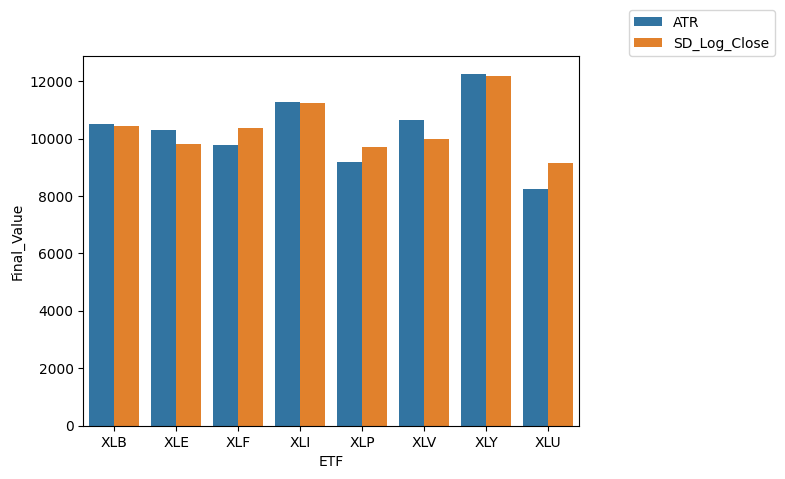

In [12]:
fig,ax = plt.subplots()
sns.barplot(data=results,x="ETF",y="Final_Value",hue="Metric",ax=ax)
plt.legend(loc=(1.1,1))
fig.savefig('return_metrics.png')
